### Description

This is the May 2025 calories prediction competition.

### Files
1. train.csv
2. test.csv
3. sample_submission.csv

### Evaluation

The evaluation metric is the RMSLE.

Submission File
For each id in the test set, you must predict the number of minutes listened. The file should contain a header and have the following format:

- id,Calories
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

## Package Importing

In [196]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import seaborn as sns

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import lightgbm as lgb

## Data Importing

In [197]:
TARGET_COLUMN = 'Calories'

In [198]:
folder_path = '../data/raw'
df_train = pd.read_csv(f'{folder_path}/train.csv')
df_test = pd.read_csv(f'{folder_path}/test.csv')
df_sample_submission = pd.read_csv(f'{folder_path}/sample_submission.csv',index_col='id')

In [199]:
df_train

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [200]:
df_train

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...,...
749995,749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [201]:
df_train.dtypes

id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

## Data Cleaning

In [202]:
from tqdm import tqdm
from itertools import combinations

def feature_engineering(df):
    
    # Encode sex as binary flag
    gender_mapping = {
        'male': 0.0,
        'female': 1.0
    }

    df['Age'] = df['Age']

    df['is_female'] = df['Sex'].map(gender_mapping)
    df = df.drop(columns=['Sex'])

    df = df.drop(columns=['id'])

    df['Duration_+_Heart_Rate'] = df['Duration'] + df['Heart_Rate']
    df['Duration_+_Body_Temp'] = df['Duration'] + df['Body_Temp']
    df['Age_+_Heart_Rate'] = df['Age'] + df['Heart_Rate']

    # columns = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp','is_female']

    # for col1, col2 in tqdm(combinations(columns,2)):
    #     new_col_name = col1 + '_*_' + col2
    #     df[new_col_name] = df[col1] * df[col2]

    return df

In [203]:
def preprocessing(X: pd.DataFrame):

    X = feature_engineering(X)

    return X # Enabled this to stop warnings



In [204]:
def target_encoding(X_train, y_train, X_test):

    ### TARGET ENCODING
    # Categorical Columns
    categorical_columns = ["Genre","Publication_Day","Episode_Sentiment","Publication_Time","Podcast_Name"]
    categorical_encoded_columns = [column_name + '_TE' for column_name in categorical_columns]

    encoder = TargetEncoder(categories='auto', smooth='auto', cv=5, random_state=42)
    encoder.fit(X_train[categorical_columns], y_train)
    X_train[categorical_encoded_columns] = encoder.transform(X_train[categorical_columns])
    X_test[categorical_encoded_columns] = encoder.transform(X_test[categorical_columns])    

    # # Interaction Columns
    # interaction_features = [
    #     ('Publication_Day','Publication_Time')
    # ]

    # interaction_features_to_be_encoded = []
    # for feature_1, feature_2 in interaction_features:
    #     feature_name = feature_1 + '_' + feature_2 + '_TE'
    #     X_train[feature_name] = (X_train[feature_1].astype('str') + '_' + X_train[feature_2].astype('str')).astype('category')
    #     X_test[feature_name] = (X_test[feature_1].astype('str') + '_' + X_test[feature_2].astype('str')).astype('category')
    #     interaction_features_to_be_encoded.append(feature_name)
    
    # encoder = TargetEncoder(categories='auto', smooth='auto', cv=5, random_state=42)
    # encoder.fit(X_train[interaction_features_to_be_encoded], y_train)
    # X_train[interaction_features_to_be_encoded] = encoder.transform(X_train[interaction_features_to_be_encoded])
    # X_test[interaction_features_to_be_encoded] = encoder.transform(X_test[interaction_features_to_be_encoded])    

    # # Fitting encoder and transforming data

    return X_train, X_test

In [205]:
def postprocessing(X:pd.DataFrame):

    columns_to_drop = [
        # 'Sex', # Already dropped in feature engineering
        # 'Age',
        # 'Height',
        # 'Weight',
        # 'Duration',
        # 'Heart_Rate',
        # 'Body_Temp',
        # 'Calories' # target variable
    ]

    X = X.drop(columns=columns_to_drop)

    return X

## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score
from sklearn.metrics import root_mean_squared_error
from xgboost.callback import EarlyStopping
from optuna.integration import XGBoostPruningCallback

NUMBER_OF_SPLITS = 4
    
outer_kfold = RepeatedKFold(n_splits=NUMBER_OF_SPLITS, n_repeats=3)

list_train_rmse = []
list_test_rmse = []

for fold_number, (infold_training_indices, infold_test_indices) in enumerate(outer_kfold.split(df_train), 1):

    # Pre-processing of training data in kfold
    X_train = df_train.loc[infold_training_indices,df_train.columns != TARGET_COLUMN]
    y_train = df_train.loc[infold_training_indices,TARGET_COLUMN]

    X_train = preprocessing(X_train)
    X_train = postprocessing(X_train)
    y_train = np.log1p(y_train)

    # Pre-processing of training data in kfold for in-fold validation
    X_test = df_train.loc[infold_test_indices,df_train.columns != TARGET_COLUMN]
    y_test = df_train.loc[infold_test_indices,TARGET_COLUMN]
    
    X_test = preprocessing(X_test)
    X_test = postprocessing(X_test)
    y_test = np.log1p(y_test)


    hyperparameters = {
    'lambda_l1': 0.0019308425132961418,
    'lambda_l2': 8.612376766701301,
    'bagging_freq': 5,
    'bagging_fraction': 0.5799027628764685,
    'feature_fraction': 0.7594543478006752,
    'learning_rate': 0.11960025124188359,
    'verbosity': 8,
    'max_depth': 6,
    'random_state': 64, 
    'num_leaves': 64,        
    'objective': 'regression',
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'n_estimators': 100, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'verbosity':0
    }
    
    model = lgb.LGBMRegressor(
        **hyperparameters
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
    )

    y_train_preds = model.predict(X_train)
    train_rmse = root_mean_squared_error(y_true=y_train,y_pred=y_train_preds)
    list_train_rmse.append(train_rmse)

    y_test_preds = model.predict(X_test)
    test_rmse = root_mean_squared_error(y_true=y_test,y_pred=y_test_preds)
    list_test_rmse.append(test_rmse)

    print(f'--- Fold {fold_number} Completed ---')
    print('train_rmse, test_rmse - ',train_rmse,test_rmse)

print('--- Training_Completed ---')
print('The average test cross root_mean_squared_error is ', sum(list_test_rmse)/len(list_test_rmse))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 will be ignored. Current value: lambda_l2=8.612376766701301
[LightGBM] [Warning] bagging_fraction is set=0.5799027628764685, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5799027628764685
[LightGBM] [Warning] feature_fraction is set=0.7594543478006752, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7594543478006752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 w

In [220]:
print('The average test cross root_mean_squared_error is ', sum(list_test_rmse)/len(list_test_rmse))

The average test cross root_mean_squared_error is  0.06187211432875045


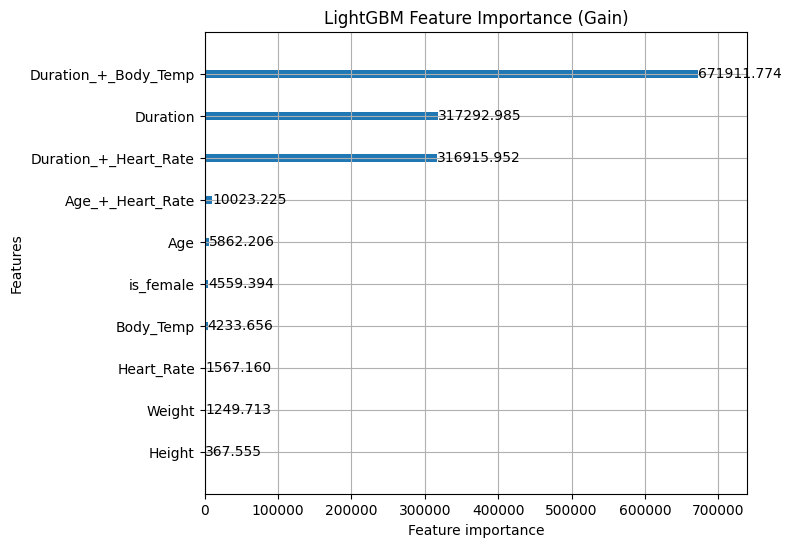

In [208]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [209]:
# Training on entire dataset
X_train = df_train.loc[:,df_train.columns != TARGET_COLUMN]
y_train = df_train.loc[:,TARGET_COLUMN]

X_train = preprocessing(X_train)    
X_train = postprocessing(X_train)
y_train = np.log1p(y_train)

# Pre-processing of training data in kfold for in-fold validation
X_test = df_test

X_test = preprocessing(X_test)
X_test = postprocessing(X_test)

model = lgb.LGBMRegressor(
    **hyperparameters,
)
model.fit(
    X_train, 
    y_train,
    eval_metric='rmse',
)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 will be ignored. Current value: lambda_l2=8.612376766701301
[LightGBM] [Warning] bagging_fraction is set=0.5799027628764685, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5799027628764685
[LightGBM] [Warning] feature_fraction is set=0.7594543478006752, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7594543478006752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 w

/var/folders/ph/4n426_w151s3mcqb32z08qq00000gn/T/ipykernel_93294/4280102658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'] = df['Age']


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(bagging_fraction=0.5799027628764685, bagging_freq=5,
              colsample_bytree=0.5, feature_fraction=0.7594543478006752,
              importance_type='gain', lambda_l1=0.0019308425132961418,
              lambda_l2=8.612376766701301, learning_rate=0.11960025124188359,
              max_depth=6, min_child_samples=10, num_leaves=64,
              objective='regression', random_state=64, reg_alpha=0.1,
              reg_lambda=1.0, subsample=0.9, subsample_freq=3, verbosity=0)

# Test Set Validation

In [210]:
y_preds = model.predict(X_test)
y_preds = np.expm1(y_preds)

[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7594543478006752, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7594543478006752
[LightGBM] [Warning] bagging_fraction is set=0.5799027628764685, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5799027628764685
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 will be ignored. Current value: lambda_l2=8.612376766701301


In [211]:
df_sample_submission 

,Calories
id,
750000,88.283
750001,88.283
750002,88.283
750003,88.283
750004,88.283
...,...
999995,88.283
999996,88.283
999997,88.283


In [212]:
import datetime

date = datetime.datetime.now().date().strftime('%Y-%m-%d')

model_type = type(model).__name__

comment = 'log_of_target_variable'

In [213]:
df_submission = df_sample_submission.copy()
df_submission[TARGET_COLUMN] = y_preds.clip(min=0,max=np.inf)

In [214]:
df_submission.Calories.min()

np.float64(1.004661838145468)

In [215]:
# write the csv to the submissions folder
df_submission.to_csv(f'../submissions/{date}-{model_type}-{comment}.csv')

In [216]:
df_submission

,Calories
id,
750000,28.179892
750001,109.641746
750002,84.678520
750003,123.125059
750004,76.275745
...,...
999995,26.171895
999996,9.630699
999997,73.364020


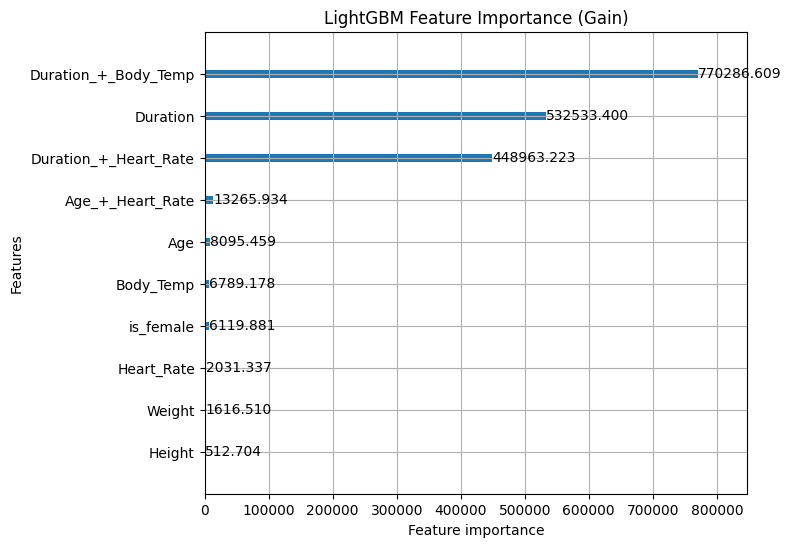

In [217]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [218]:
# CHECKLIST BEFORE RUNNING
# 1. is this a new run (start_run run_id empty) or are you inserting into an old run (start run populated)
# 2. Do you know the kaggle leaderboard metric? If not set to 999
# 3. Is this a leaderboard model? If not then disable the model logging at the end
# This take 2 minutes to run

import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri("http://localhost:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Kaggle S5E5")

# Start an MLflow run
with mlflow.start_run():

    # Log the hyperparameters
    mlflow.log_params(hyperparameters)

    # Log the loss metric
    mlflow.log_metric("cv_score", sum(list_test_rmse)/len(list_test_rmse))
    mlflow.log_metric("kaggle leaderboard", 0.16078)

    # Infer the model signature
    signature = infer_signature(
        model_input=X_train,
        model_output=y_train,
    )

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        signature=signature,
        input_example=X_train,
    );

/Users/cbutler/repos/personal_repos/KAGGLE_S5E5/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.0019308425132961418, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.0019308425132961418
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=3 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7594543478006752, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7594543478006752
[LightGBM] [Warning] bagging_fraction is set=0.5799027628764685, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5799027628764685
[LightGBM] [Warning] lambda_l2 is set=8.612376766701301, reg_lambda=1.0 will be ignored. Current value: lambda_l2=8.612376766701301
🏃 View run painted-crow-268 at: http://localhost:5000/#/experiments/4/runs/0cd6ba327b6845b1a97ac2bf96859d7f
🧪 View experiment at: http://localhost:5000/#/experiments/4
